# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../theory/sliding_windows_google.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

2400.0

In [143]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 2400   

t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,-0.314073
1,0.402588
2,-0.050265
3,0.648512
4,0.075845


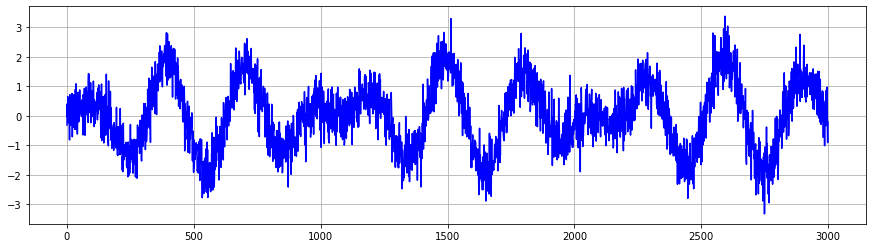

In [144]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True)
plt.show()

In [145]:
values = df.values
train, test = values[0:Tp ,:], values[Tp:N,:]

In [146]:
print(train.shape)
print(test.shape)

(2400, 1)
(600, 1)


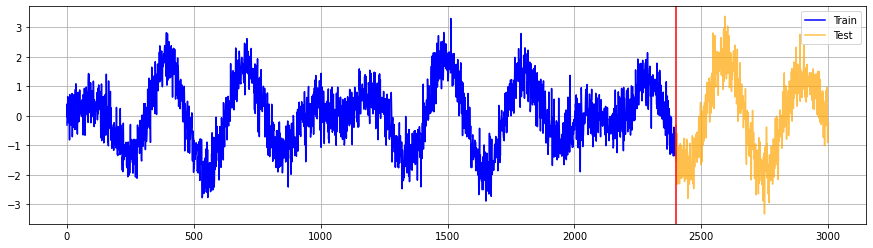

In [147]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

### Convert data to train

In [155]:
step = 0

In [168]:
def convertToMatrix(data):
    X, Y =[], []
    for i in range(len(data)):
        d=i
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [169]:
train.shape

(2400, 1)

In [176]:

trainX,trainY = convertToMatrix(train)
testX,testY = convertToMatrix(test)

In [177]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (2400, 0, 1) ,  (2400, 1)
Test data shape: (600, 0, 1) ,  (600, 1)


In [178]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

TypeError: order must be str, not int

In [161]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [162]:
model = build_simple_rnn()

In [163]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


In [164]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 10 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [165]:
batch_size=16
num_epochs = 100

In [166]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

ValueError: in user code:

    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_2: expected shape=(None, None, 4), found shape=(16, 1, 0)


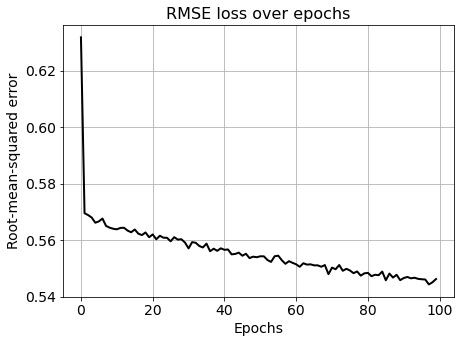

In [102]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

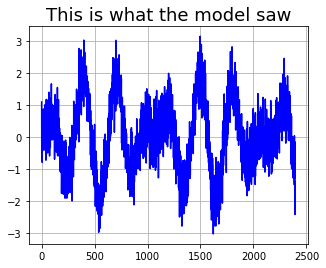

In [103]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [104]:
testX.shape

(596, 1, 4)

In [105]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

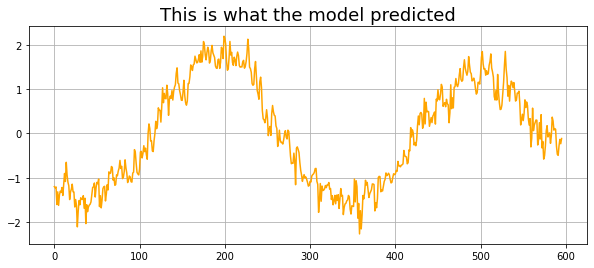

In [106]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

In [107]:
error = predicted[Tp:N]-df[Tp:N]
error = np.array(error).ravel()

ValueError: Unable to coerce to DataFrame, shape must be (600, 1): given (592, 1)

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()